# NEW

# Movielens 영화 SBR

루브릭
Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.


# Step 0. 데이터 불러오기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/EXP_12_yoochoose/data') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다.

그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

Rating 정보가 포함되어 있습니다.

무시하고 제외할 수 있습니다만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다.

아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

## Step 1. 데이터의 전처리

In [3]:
# 유저수(세션 수)와 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
# 유저별 리뷰 갯수
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
# 리뷰 중앙값, 평균 리뷰 수
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [6]:
# 리뷰 최소값, 리뷰 최댓값
session_length.min(), session_length.max()

(20, 2314)

In [7]:
# 리뷰 분위수(전체 데이터의 0.999%)
session_length.quantile(0.999)

1343.181000000005

In [8]:
# 최다 리뷰자 확인해보기
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


### 세션 길이 시각화

세션 길이에 따른 분포 확인해보기

In [9]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

In [10]:
group_by_user = data.groupby('UserId').size()

group_by_user.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [11]:
group_by_user.quantile(0.999)

1343.181000000005

보통 한 사람이 평가를 준 영화 수는 165개이다.
상위 25%로 많이 준 사람은 208개인데 한 사람이 최대로 준 영화 편 수가 2314이다.
99.9%의 사용자는 1343개의 영화를 평가했는데 이는 최대치인 2314과 많이 차이나는 것을 알 수 있다.

In [12]:
long_session = group_by_user[group_by_user==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


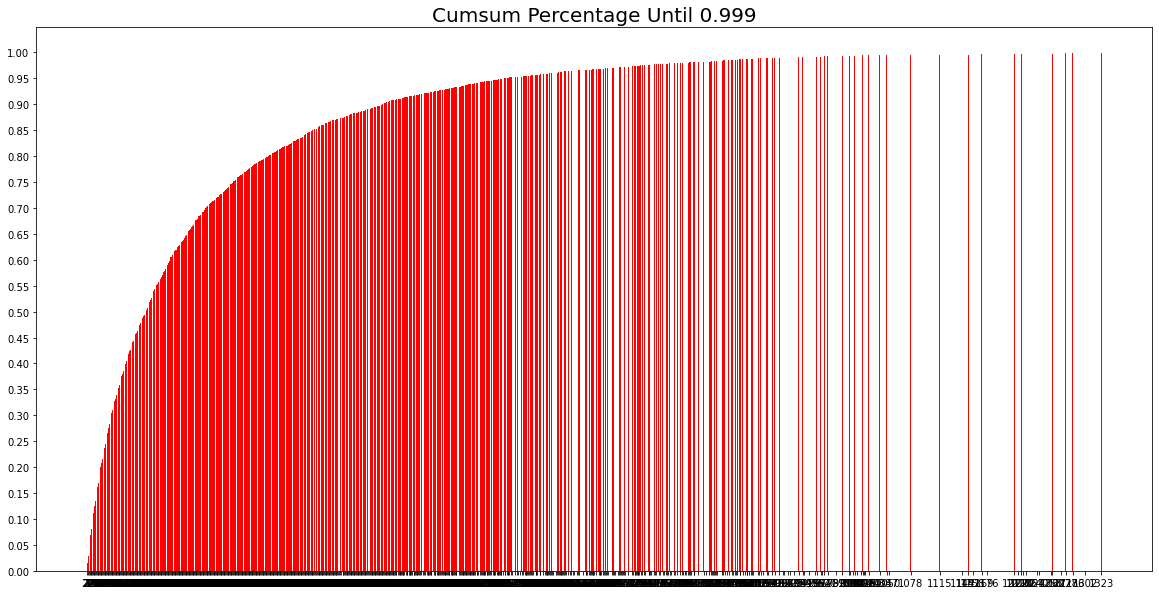

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [14]:
print(f'데이터 총 개수: {len(data)}')

데이터 총 개수: 1000209


<AxesSubplot:>

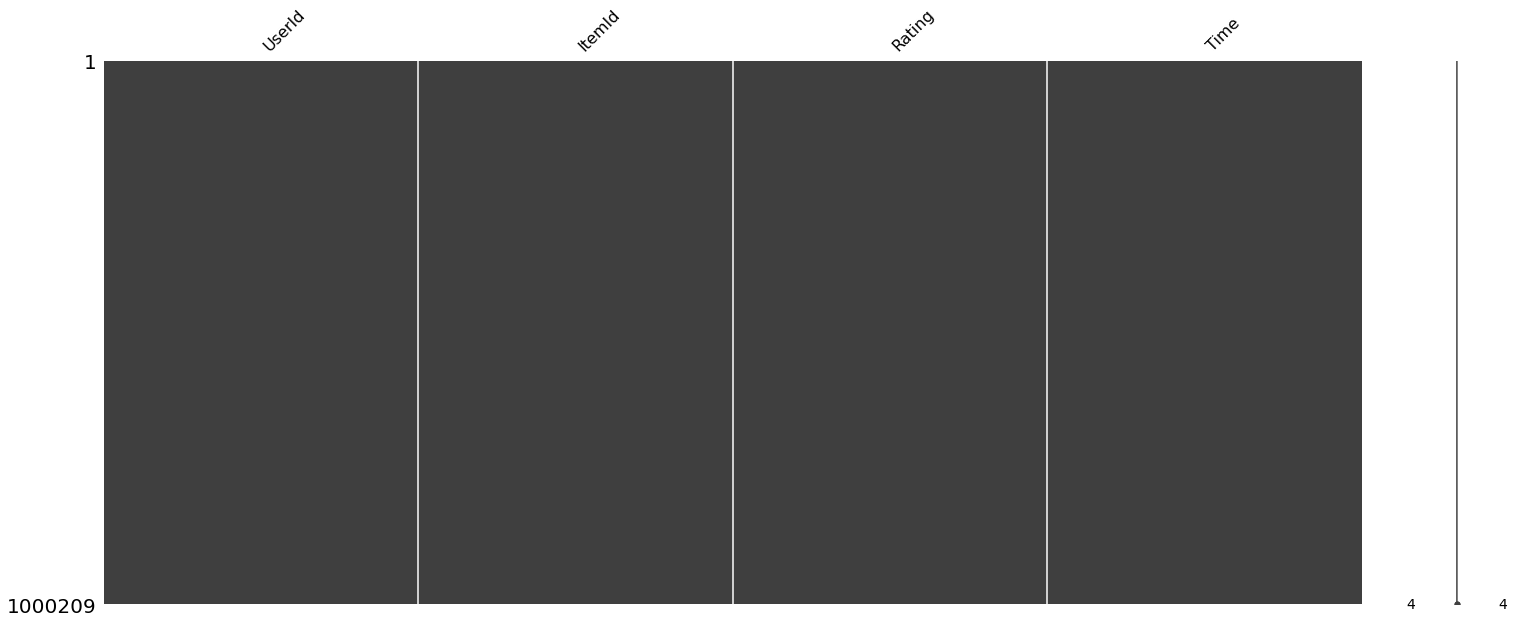

In [15]:
import missingno as msno
msno.matrix(data)

### Rating

Rating 정보 확인 및 변경
Rating은 최고 5점으로 시청한 영화가 맘에 들었는지 여부를 판단합니다.
Rating의 정보로 비슷한 영화를 더 고르게 할 수도 있습니다.
Rating이 낮은 데이터는 삭제를 합니다.

In [16]:
print(f"Rating 종류: {data['Rating'].unique()}")

Rating 종류: [4 5 3 2 1]


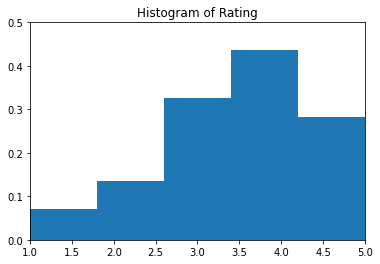

In [17]:
plt.hist(data['Rating'], density=True,bins=5)
plt.title('Histogram of Rating')
plt.axis([1, 5, 0, 0.5])
plt.show()


평점 1점과 2점 데이터의 분포가 적어 삭제하도록 합니다.

In [18]:
change_Rating = data[data['Rating']>=3]
print(len(change_Rating))

836478


In [19]:
change_Rating = data[data['Rating']>=3]
print(len(change_Rating))

836478


### Session Time

데이터의 시간 정보 확인 및 변경

In [20]:
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


Time을 확인해보면 978300019으로 확인하기 어렵게 기재되어 있습니다.
편리한 이용을 위해서 Time의 내용을 fromtimestamp()를 이용해 변경합니다.

In [21]:
data["Time"] = data["Time"].apply(lambda x: dt.datetime.fromtimestamp(x, dt.timezone.utc))
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19+00:00
22,1,1270,5,2000-12-31 22:00:55+00:00
27,1,1721,4,2000-12-31 22:00:55+00:00
37,1,1022,5,2000-12-31 22:00:55+00:00
24,1,2340,3,2000-12-31 22:01:43+00:00


In [22]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32+00:00
2003-02-28 17:49:50+00:00


이 데이터셋은 대략 2년이 넘는 데이터를 가지고 있다.
하지만 사용자들의 소비패턴은 금방 변하기 때문에 최근 데이터를 학습하는 것이 좋다.

3달치, 6달치 데이터 중 어느 기간이 성능이 좋아지는지 확인하는 것도 좋을 듯 하다.

In [109]:
def get_data_before_month(data, month):
    latest = data['Time'].max()
    month_ago = latest - dt.timedelta(month*30)
    data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
    print(f'length:{len(data)}')
    oldest, latest = data['Time'].min(), data['Time'].max()
    print(f'oldest: {oldest}') 
    print(f'latest: {latest}')
    return data

data_1 = get_data_before_month(data, 1)
data_3 = get_data_before_month(data, 3)
data_6 = get_data_before_month(data, 6)
data_12 = get_data_before_month(data, 12)

length:1551
oldest: 2003-01-29 19:36:56+00:00
latest: 2003-02-28 17:49:50+00:00
length:4610
oldest: 2002-11-30 20:24:52+00:00
latest: 2003-02-28 17:49:50+00:00
length:8806
oldest: 2002-09-01 19:41:39+00:00
latest: 2003-02-28 17:49:50+00:00
length:21055
oldest: 2002-03-05 18:25:38+00:00
latest: 2003-02-28 17:49:50+00:00


### Data Cleansing

In [24]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [25]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19+00:00
22,1,1270,5,2000-12-31 22:00:55+00:00
27,1,1721,4,2000-12-31 22:00:55+00:00
37,1,1022,5,2000-12-31 22:00:55+00:00
24,1,2340,3,2000-12-31 22:01:43+00:00
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29+00:00
999988,6040,1921,4,2001-08-10 14:41:04+00:00
1000172,6040,1784,3,2001-08-10 14:41:04+00:00
1000167,6040,161,3,2001-08-10 14:41:26+00:00


In [105]:
data_1 = cleanse_recursive(data_1, shortest=2, least_click=5)
data_1

,UserId,ItemId,Rating,Time
58836,398,2028,4,2003-02-06 21:03:45+00:00
58784,398,2762,5,2003-02-06 21:09:13+00:00
58730,398,2628,3,2003-02-06 21:18:16+00:00
58837,398,3697,2,2003-02-06 21:21:04+00:00
58645,398,1196,4,2003-02-06 21:39:01+00:00
62105,419,2424,4,2003-02-10 18:10:24+00:00
62170,419,2028,5,2003-02-10 18:13:21+00:00
62078,419,1196,5,2003-02-10 18:15:20+00:00
62145,419,2762,5,2003-02-10 18:22:08+00:00
62071,419,3793,4,2003-02-10 18:22:34+00:00


In [106]:
data_3 = cleanse_recursive(data_3, shortest=2, least_click=5)
data_3

,UserId,ItemId,Rating,Time
5364,36,3786,4,2002-12-22 08:08:41+00:00
5280,36,3174,4,2002-12-22 08:11:25+00:00
5222,36,296,5,2002-12-22 08:16:59+00:00
5062,36,1266,5,2002-12-22 08:18:29+00:00
5076,36,595,4,2002-12-22 08:18:29+00:00
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57+00:00
984682,5950,3578,4,2003-02-27 18:14:30+00:00
984475,5950,3793,3,2003-02-27 18:15:10+00:00
984660,5950,3555,2,2003-02-27 18:15:37+00:00


In [107]:
data_6 = cleanse_recursive(data_6, shortest=2, least_click=5)
data_6

,UserId,ItemId,Rating,Time
5200,36,2269,5,2002-12-22 08:05:50+00:00
5364,36,3786,4,2002-12-22 08:08:41+00:00
5262,36,2369,4,2002-12-22 08:09:24+00:00
5280,36,3174,4,2002-12-22 08:11:25+00:00
5222,36,296,5,2002-12-22 08:16:59+00:00
...,...,...,...,...
984475,5950,3793,3,2003-02-27 18:15:10+00:00
984660,5950,3555,2,2003-02-27 18:15:37+00:00
984733,5950,1262,4,2003-02-27 18:17:38+00:00
992459,5996,339,4,2002-10-07 13:24:39+00:00


In [110]:
data_12 = cleanse_recursive(data_12, shortest=2, least_click=5)
data_12

,UserId,ItemId,Rating,Time
5170,36,1387,5,2002-03-12 03:46:59+00:00
5267,36,1201,4,2002-03-12 03:46:59+00:00
5122,36,1291,5,2002-03-12 03:47:16+00:00
5123,36,2167,5,2002-03-12 03:48:25+00:00
5290,36,2951,4,2002-03-12 03:48:25+00:00
...,...,...,...,...
992466,5996,3564,3,2002-04-29 20:33:12+00:00
992279,5996,2422,3,2002-04-29 20:47:05+00:00
992702,5996,168,3,2002-09-03 13:12:26+00:00
992459,5996,339,4,2002-10-07 13:24:39+00:00


## Step 2. 미니 배치의 구성


실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다.


Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.


단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    return before_date, after_date

In [29]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [111]:
tr_1, test_1 = split_by_date(data_1, n_days=180)
tr_1, val_1 = split_by_date(tr_1, n_days=180)

In [112]:
tr_3, test_3 = split_by_date(data_3, n_days=180)
tr_3, val_3 = split_by_date(tr_3, n_days=180)

In [114]:
tr_6, test_6 = split_by_date(data_6, n_days=180)
tr_6, val_6 = split_by_date(tr_6, n_days=180)

In [115]:
tr_12, test_12 = split_by_date(data_12, n_days=180)
tr_12, val_12 = split_by_date(tr_12, n_days=180)

In [30]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978534
	 Sessions: 6038
	 Items: 3416
	 First Time : 2000-04-25 23:05:32+00:00
	 Last Time : 2002-03-05 04:19:56+00:00

* valid Set Stats Info
	 Events: 12271
	 Sessions: 399
	 Items: 2606
	 First Time : 2002-03-05 04:21:07+00:00
	 Last Time : 2002-09-01 04:20:59+00:00

* test Set Stats Info
	 Events: 8806
	 Sessions: 339
	 Items: 2317
	 First Time : 2002-09-01 19:41:39+00:00
	 Last Time : 2003-02-28 17:49:50+00:00



Events: 데이터 갯수


Sessions: UserId의 고유값


Items: ItemId의 고유값


First Time : 최소시간


Last Time : 최대시간

In [116]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
def indexing(df):
    id2idx = {item_id : index for index, item_id in enumerate(df['ItemId'].unique())}
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr)
val = indexing(val)
test = indexing(test)


tr_1 = indexing(tr_1)
val_1 = indexing(val_1)
test_1 = indexing(test_1)



tr_3 = indexing(tr_3)
val_3 = indexing(val_3)
test_3 = indexing(test_3)



tr_6 = indexing(tr_6)
val_6 = indexing(val_6)
test_6 = indexing(test_6)



tr_12 = indexing(tr_12)
val_12 = indexing(val_12)
test_12 = indexing(test_12)

In [119]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')



tr_1.to_pickle(save_path / 'train_1.pkl')
val_1.to_pickle(save_path / 'valid_1.pkl')
test_1.to_pickle(save_path / 'test_1.pkl')


tr_3.to_pickle(save_path / 'train_3.pkl')
val_3.to_pickle(save_path / 'valid_3.pkl')
test_3.to_pickle(save_path / 'test_3.pkl')



tr_6.to_pickle(save_path / 'train_6.pkl')
val_6.to_pickle(save_path / 'valid_6.pkl')
test_6.to_pickle(save_path / 'test_6.pkl')



tr_12.to_pickle(save_path / 'train_12.pkl')
val_12.to_pickle(save_path / 'valid_12.pkl')
test_12.to_pickle(save_path / 'test_12.pkl')


In [34]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [35]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19+00:00,0
22,1,1270,5,2000-12-31 22:00:55+00:00,1
27,1,1721,4,2000-12-31 22:00:55+00:00,2
37,1,1022,5,2000-12-31 22:00:55+00:00,3
24,1,2340,3,2000-12-31 22:01:43+00:00,4
36,1,1836,5,2000-12-31 22:02:52+00:00,5
3,1,3408,4,2000-12-31 22:04:35+00:00,6
7,1,2804,5,2000-12-31 22:11:59+00:00,7
47,1,1207,4,2000-12-31 22:11:59+00:00,8
0,1,1193,5,2000-12-31 22:12:40+00:00,9


In [123]:
tr_1_dataset = SessionDataset(tr_1)
tr_1_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx


In [ ]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

In [ ]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

In [36]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978070, 978193, 978534], dtype=int32)

In [37]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

In [38]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [39]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19+00:00,0
22,1,1270,5,2000-12-31 22:00:55+00:00,1
27,1,1721,4,2000-12-31 22:00:55+00:00,2
37,1,1022,5,2000-12-31 22:00:55+00:00,3
24,1,2340,3,2000-12-31 22:01:43+00:00,4
36,1,1836,5,2000-12-31 22:02:52+00:00,5
3,1,3408,4,2000-12-31 22:04:35+00:00,6
7,1,2804,5,2000-12-31 22:11:59+00:00,7
47,1,1207,4,2000-12-31 22:11:59+00:00,8
0,1,1193,5,2000-12-31 22:12:40+00:00,9


In [40]:
iter_ex = iter(tr_data_loader)

In [41]:
for i in range(5):
    inputs, labels, mask =  next(iter_ex)
    print(f'Model Input Item Idx are : {inputs}')
    print(f'Label Item Idx are : {"":5} {labels}')
    print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []
Model Input Item Idx are : [ 1 54 62 24]
Label Item Idx are :       [  2  55 175  67]
Previous Masked Input Idx are []
Model Input Item Idx are : [  2  55 175  67]
Label Item Idx are :       [  3  56  91 134]
Previous Masked Input Idx are []
Model Input Item Idx are : [  3  56  91 134]
Label Item Idx are :       [  4  57 176 208]
Previous Masked Input Idx are []
Model Input Item Idx are : [  4  57 176 208]
Label Item Idx are :       [ 5 58 15 11]
Previous Masked Input Idx are []


## Step 3. Modeling

Evaluation Metric
Session Based Recommendation Task에서는 recall과 precision 개념을 확장한 recall@k, Mean Average Precision@k 지표등을 사용한다.
또 추천에서는 몇 번째로 맞추느냐도 중요하기 때문에 순서에 민감한 지표인 MRR, NDCG도 사용한다.

Average Precision때문에 대개는 P@K보다는 R@K을 많이 사용하는 듯 하다.- https://jyoondev.tistory.com/130

In [42]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [43]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [48]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20)

In [49]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

In [50]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args, display_flg=True):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask) 

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k, display_flg) 

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
    
    return val_recall, val_mrr


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU') 
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask: 
        hidden_states[elt, :] = 0  
    gru_layer.reset_states(states=hidden_states)

def display_metrics(recall, mrr):
    plt.figure(figsize=(8,5))
    plt.plot(recall, color='red', label='recall')
    plt.plot(mrr, label='mrr')
    plt.legend()
    plt.show()
    
def get_metrics(data, model, args, k: int, display_flg=True): 
                                            
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])

        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    if display_flg==True:     
        display_metrics(recall_list, mrr_list)
    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

Evaluation:  45%|████▍     | 41/92 [00:31<00:39,  1.29it/s]


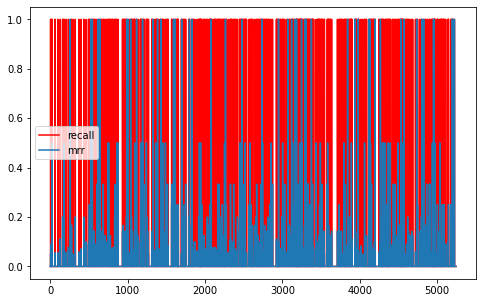

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.14] 

	 - Recall@20 epoch 1: 0.097180
	 - MRR@20    epoch 1: 0.024286



Evaluation:  45%|████▍     | 41/92 [00:32<00:40,  1.25it/s]


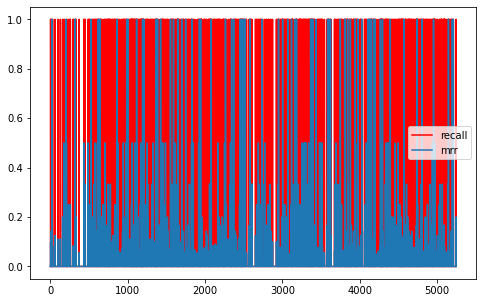

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.8] 

	 - Recall@20 epoch 2: 0.118902
	 - MRR@20    epoch 2: 0.033500



Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.33it/s]


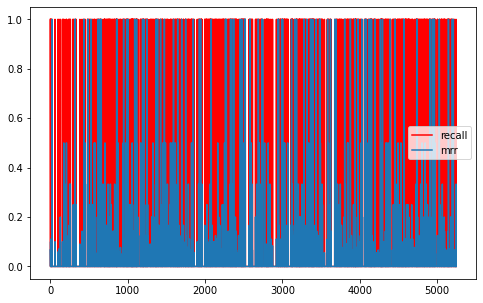

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.03]

	 - Recall@20 epoch 3: 0.129192
	 - MRR@20    epoch 3: 0.036597



Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.33it/s]


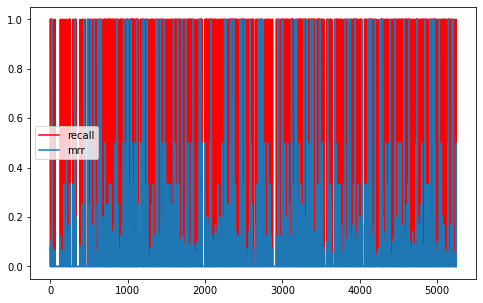

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.52]  

	 - Recall@20 epoch 4: 0.135099
	 - MRR@20    epoch 4: 0.037837



Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.33it/s]


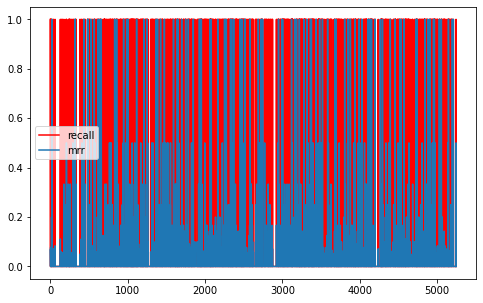

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.45]  

	 - Recall@20 epoch 5: 0.138720
	 - MRR@20    epoch 5: 0.039710



Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.33it/s]


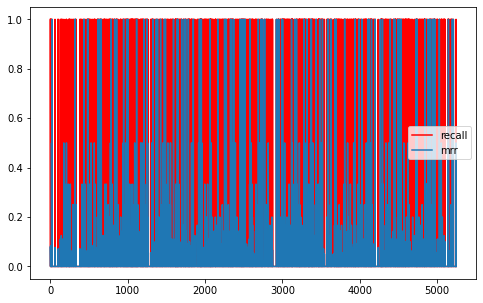

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.172, train_loss=5.44]  

	 - Recall@20 epoch 6: 0.138338
	 - MRR@20    epoch 6: 0.040364



Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.33it/s]


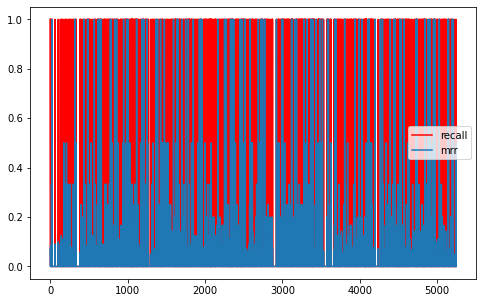

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.133, train_loss=5.4]   

	 - Recall@20 epoch 7: 0.138910
	 - MRR@20    epoch 7: 0.040509



Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.33it/s]


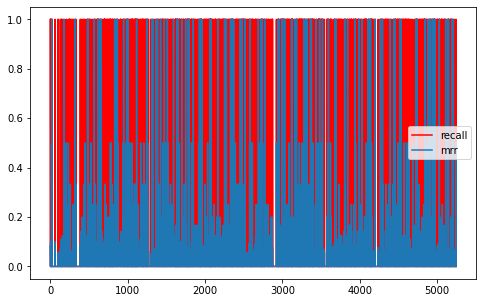

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.42] 

	 - Recall@20 epoch 8: 0.140244
	 - MRR@20    epoch 8: 0.041572



Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.33it/s]


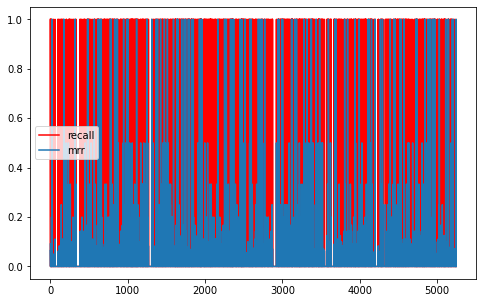

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.102, train_loss=5.45]  

	 - Recall@20 epoch 9: 0.142149
	 - MRR@20    epoch 9: 0.041948



Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.32it/s]


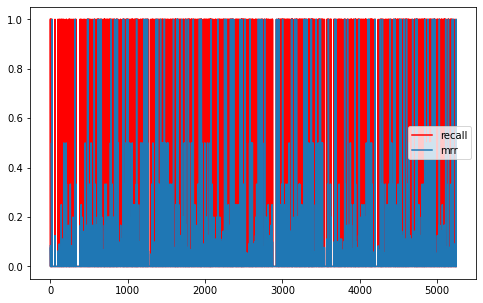

	 - Recall@20 epoch 10: 0.140625
	 - MRR@20    epoch 10: 0.041798



(0.140625, 0.04179802346470881)

In [51]:
train_model(model, args)

## Step 5. 모델 테스트

Evaluation:  36%|███▋      | 24/66 [00:18<00:33,  1.26it/s]


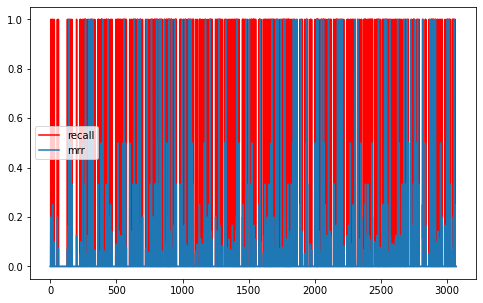

	 - Recall@20: 0.149089
	 - MRR@20: 0.045714



In [52]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

## Step 6. 모델 개선
1. 학습률 변경
1-1. lr=0.01 변경

Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.33it/s]


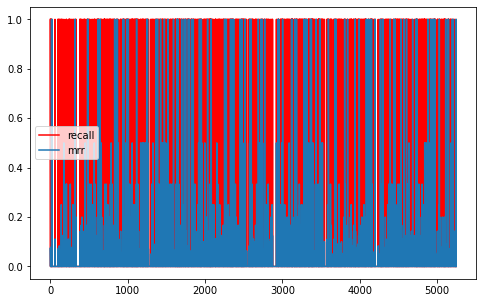

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.48]  

	 - Recall@20 epoch 1: 0.141006
	 - MRR@20    epoch 1: 0.042322



Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.32it/s]


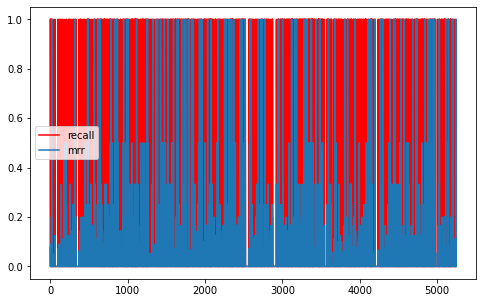

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.23] 

	 - Recall@20 epoch 2: 0.139482
	 - MRR@20    epoch 2: 0.041464



Evaluation:  45%|████▍     | 41/92 [00:30<00:38,  1.33it/s]


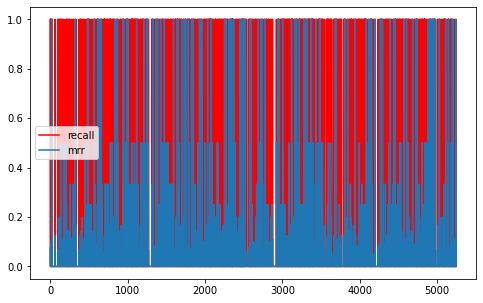

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.141, train_loss=5.32]  

	 - Recall@20 epoch 3: 0.137767
	 - MRR@20    epoch 3: 0.041858



Evaluation:  45%|████▍     | 41/92 [01:06<01:22,  1.61s/it]


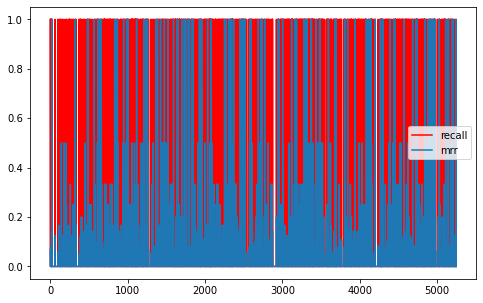

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.31]

	 - Recall@20 epoch 4: 0.140053
	 - MRR@20    epoch 4: 0.042570



Evaluation:  45%|████▍     | 41/92 [01:06<01:23,  1.63s/it]


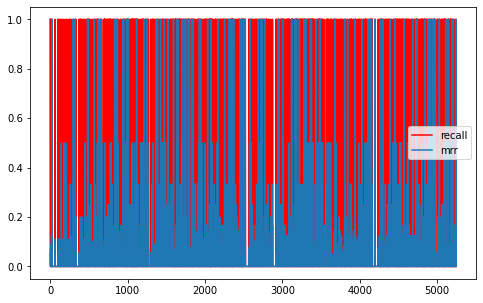

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0234, train_loss=7.38]

	 - Recall@20 epoch 5: 0.139672
	 - MRR@20    epoch 5: 0.042440



Evaluation:  45%|████▍     | 41/92 [01:06<01:22,  1.61s/it]


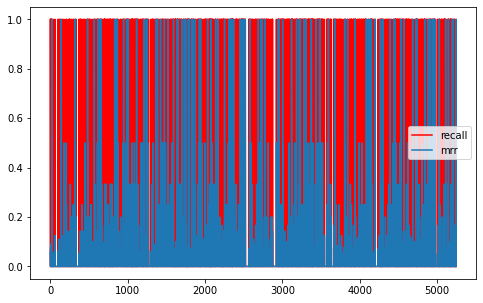

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.36]

	 - Recall@20 epoch 6: 0.141387
	 - MRR@20    epoch 6: 0.042173



Evaluation:  45%|████▍     | 41/92 [01:06<01:22,  1.62s/it]


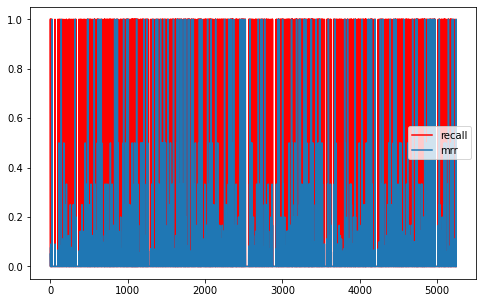

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0, train_loss=7.34]      

	 - Recall@20 epoch 7: 0.140625
	 - MRR@20    epoch 7: 0.041998



Evaluation:  45%|████▍     | 41/92 [01:06<01:22,  1.62s/it]


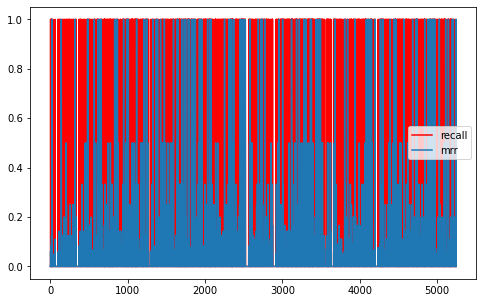

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.38]

	 - Recall@20 epoch 8: 0.139863
	 - MRR@20    epoch 8: 0.042700



Evaluation:  45%|████▍     | 41/92 [01:05<01:21,  1.60s/it]


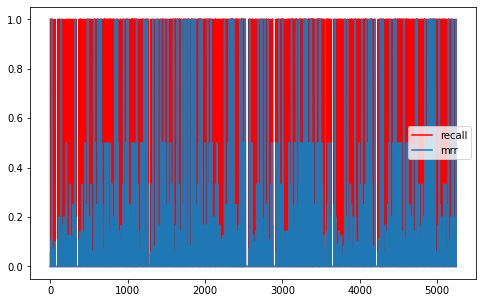

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.3] 

	 - Recall@20 epoch 9: 0.138720
	 - MRR@20    epoch 9: 0.042503



Evaluation:  45%|████▍     | 41/92 [01:05<01:21,  1.60s/it]


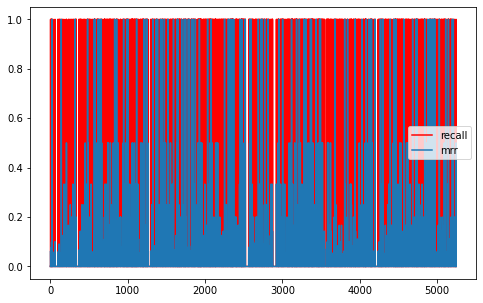

	 - Recall@20 epoch 10: 0.139101
	 - MRR@20    epoch 10: 0.042614



(0.13910060975609756, 0.04261439882785977)

In [53]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)
train_model(model, args)

Evaluation:  36%|███▋      | 24/66 [00:41<01:13,  1.74s/it]


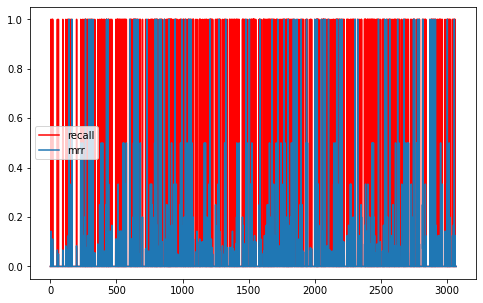

	 - Recall@20: 0.152344
	 - MRR@20: 0.046234



In [54]:
test_model(model, args, test)

cs231n에서 하이퍼파라미터 조정할 때 학습률 먼저 확인해본다길래 건들여봤는데 엄청나게 상향된 것 같지 않다.


정확도도 그렇고 매트릭스도 그렇고 수치가 안돌리는것만 못한 수치가 나왔다.


배치사이즈 이것저것 시도해봤는데 너무 크면 안돌아가고 작으면 텐서가 맞지 않는다고 나온다.


그래도 긍정적으로 생각해보면 위에 시도한 것보다 약간 나아졌다.

## 2. drop_rate 변경
2-1. drop_rate=0.5

Evaluation:  45%|████▍     | 41/92 [01:05<01:22,  1.61s/it]


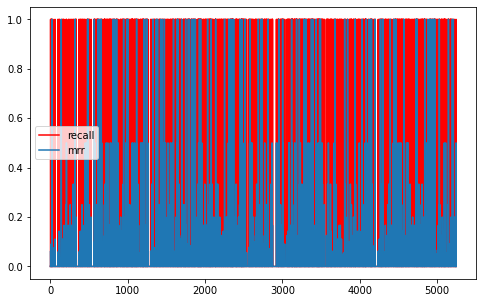

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0312, train_loss=7.37]

	 - Recall@20 epoch 1: 0.138148
	 - MRR@20    epoch 1: 0.041973



Evaluation:  45%|████▍     | 41/92 [01:05<01:21,  1.59s/it]


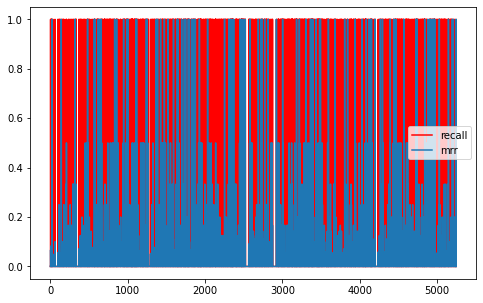

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.29]

	 - Recall@20 epoch 2: 0.138529
	 - MRR@20    epoch 2: 0.042021



Evaluation:  45%|████▍     | 41/92 [01:05<01:21,  1.60s/it]


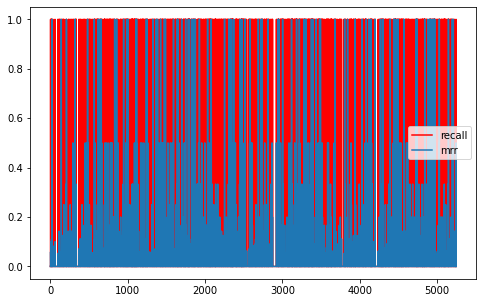

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.29]

	 - Recall@20 epoch 3: 0.140244
	 - MRR@20    epoch 3: 0.042274



Evaluation:  45%|████▍     | 41/92 [01:05<01:21,  1.60s/it]


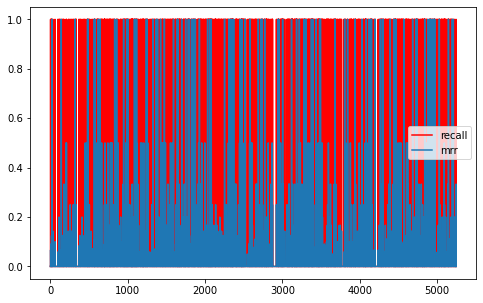

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.3]

	 - Recall@20 epoch 4: 0.140625
	 - MRR@20    epoch 4: 0.041823



Evaluation:  45%|████▍     | 41/92 [01:06<01:22,  1.61s/it]


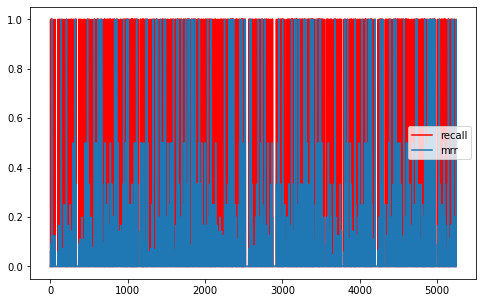

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.28]

	 - Recall@20 epoch 5: 0.138148
	 - MRR@20    epoch 5: 0.041975



Evaluation:  45%|████▍     | 41/92 [01:05<01:21,  1.60s/it]


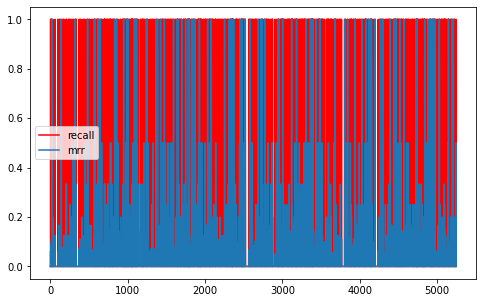

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.3] 

	 - Recall@20 epoch 6: 0.138529
	 - MRR@20    epoch 6: 0.041045



Evaluation:  45%|████▍     | 41/92 [01:06<01:22,  1.62s/it]


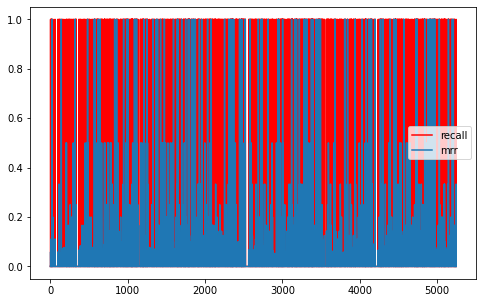

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.22]

	 - Recall@20 epoch 7: 0.138529
	 - MRR@20    epoch 7: 0.042249



Evaluation:  45%|████▍     | 41/92 [01:06<01:22,  1.62s/it]


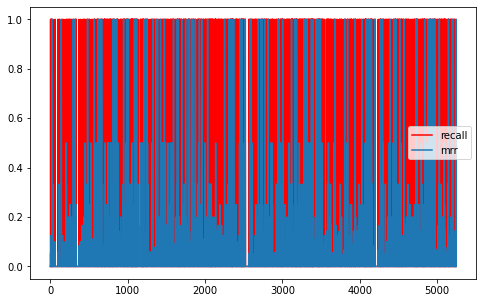

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.29]

	 - Recall@20 epoch 8: 0.138529
	 - MRR@20    epoch 8: 0.042661



Evaluation:  45%|████▍     | 41/92 [01:05<01:21,  1.59s/it]


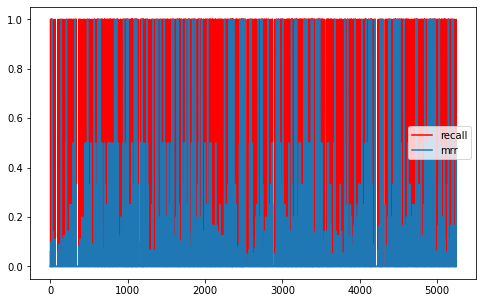

Train:   0%|          | 0/7597 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.23] 

	 - Recall@20 epoch 9: 0.136814
	 - MRR@20    epoch 9: 0.042559



Evaluation:  45%|████▍     | 41/92 [01:05<01:21,  1.60s/it]


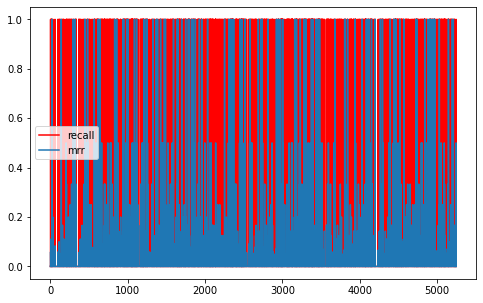

	 - Recall@20 epoch 10: 0.138720
	 - MRR@20    epoch 10: 0.042294



(0.13871951219512196, 0.04229382419815721)

In [55]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.5, lr=0.1, epochs=10, k=20)
train_model(model, args)

Evaluation:  36%|███▋      | 24/66 [00:37<01:06,  1.58s/it]


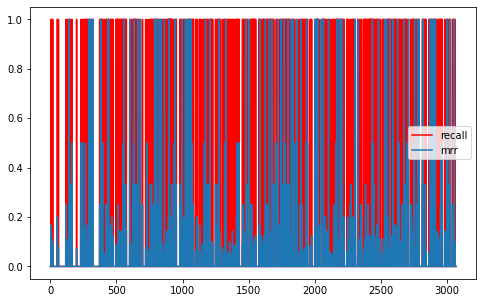

	 - Recall@20: 0.153320
	 - MRR@20: 0.047378



In [56]:
test_model(model, args, test)

에폭이 낮아서 그런지 드롭아웃 여부가 크게 기여하지 않는 것 같다.

## 루브릭 관련 고려한 점
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.

데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.

2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.

적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.


3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.

2가지 이상의 변화를 시도했다.


## 1개월치 데이터 사용

In [85]:
data_1 = get_data_before_month(data, 1)
data_1 = cleanse_recursive(data_1, shortest=2, least_click=5)

length:1551
oldest: 2003-01-29 19:36:56+00:00
latest: 2003-02-28 17:49:50+00:00


In [86]:
data_1 = cleanse_recursive(data_1, shortest=2, least_click=5)
data_1

,UserId,ItemId,Rating,Time
58836,398,2028,4,2003-02-06 21:03:45+00:00
58784,398,2762,5,2003-02-06 21:09:13+00:00
58730,398,2628,3,2003-02-06 21:18:16+00:00
58837,398,3697,2,2003-02-06 21:21:04+00:00
58645,398,1196,4,2003-02-06 21:39:01+00:00
62105,419,2424,4,2003-02-10 18:10:24+00:00
62170,419,2028,5,2003-02-10 18:13:21+00:00
62078,419,1196,5,2003-02-10 18:15:20+00:00
62145,419,2762,5,2003-02-10 18:22:08+00:00
62071,419,3793,4,2003-02-10 18:22:34+00:00


In [87]:
tr, test = split_by_date(data_1, n_days=5)
tr, val = split_by_date(tr, n_days=5)
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 19
	 Sessions: 4
	 Items: 7
	 First Time : 2003-02-01 02:39:15+00:00
	 Last Time : 2003-02-10 18:22:34+00:00

* valid Set Stats Info
	 Events: 9
	 Sessions: 2
	 Items: 6
	 First Time : 2003-02-16 23:59:49+00:00
	 Last Time : 2003-02-21 21:22:26+00:00

* test Set Stats Info
	 Events: 7
	 Sessions: 3
	 Items: 5
	 First Time : 2003-02-24 17:02:07+00:00
	 Last Time : 2003-02-27 18:15:10+00:00



In [99]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
def indexing(df):
    id2idx = {item_id : index for index, item_id in enumerate(df['ItemId'].unique())}
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr)
val = indexing(val)
test = indexing(test)

In [100]:
tr = indexing(tr,)
val = indexing(val)
test = indexing(test)

In [101]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train_1month.pkl')
val.to_pickle(save_path / 'valid_1month.pkl')
test.to_pickle(save_path / 'test_1month.pkl')

In [95]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
58836,398,2028,4,2003-02-06 21:03:45+00:00,0
58784,398,2762,5,2003-02-06 21:09:13+00:00,1
58730,398,2628,3,2003-02-06 21:18:16+00:00,2
58837,398,3697,2,2003-02-06 21:21:04+00:00,3
58645,398,1196,4,2003-02-06 21:39:01+00:00,4
62105,419,2424,4,2003-02-10 18:10:24+00:00,5
62170,419,2028,5,2003-02-10 18:13:21+00:00,0
62078,419,1196,5,2003-02-10 18:15:20+00:00,4
62145,419,2762,5,2003-02-10 18:22:08+00:00,1
62071,419,3793,4,2003-02-10 18:22:34+00:00,6


Train:   0%|          | 0/326 [00:00<?, ?it/s]

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(4, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(4, 50), (4, 50)]        42450     
_________________________________________________________________
dropout_10 (Dropout)         (4, 50)                   0         
_________________________________________________________________
dense_10 (Dense)             (4, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Evaluation:  67%|██████▋   | 10/15 [00:00<00:00, 13.01it/s]


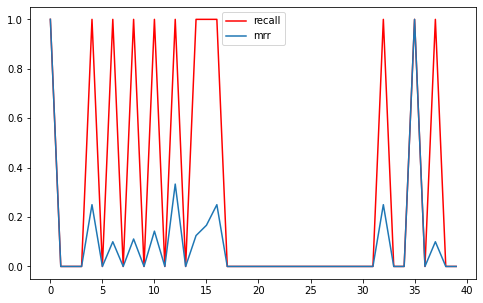

Train:   0%|          | 0/326 [00:00<?, ?it/s, accuracy=0, train_loss=5.31]   

	 - Recall@10 epoch 1: 0.300000
	 - MRR@10    epoch 1: 0.095724



Evaluation:  67%|██████▋   | 10/15 [00:00<00:00, 20.84it/s]


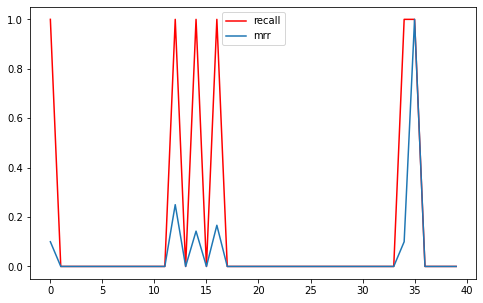

Train:   0%|          | 0/326 [00:00<?, ?it/s, accuracy=0, train_loss=5.25]   

	 - Recall@10 epoch 2: 0.150000
	 - MRR@10    epoch 2: 0.043988



Evaluation:  67%|██████▋   | 10/15 [00:00<00:00, 21.28it/s]


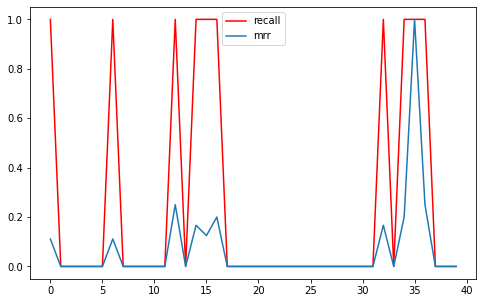

Train:   0%|          | 0/326 [00:00<?, ?it/s, accuracy=0, train_loss=4.79]   

	 - Recall@10 epoch 3: 0.250000
	 - MRR@10    epoch 3: 0.064514



Evaluation:  67%|██████▋   | 10/15 [00:00<00:00, 21.33it/s]


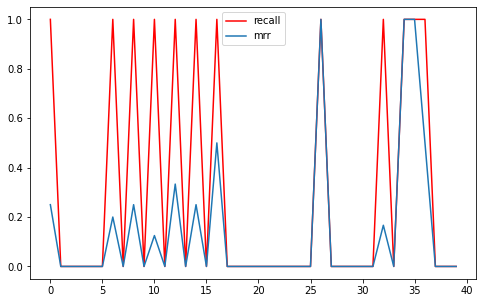

Train:   0%|          | 0/326 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.85]

	 - Recall@10 epoch 4: 0.300000
	 - MRR@10    epoch 4: 0.139375



Evaluation:  67%|██████▋   | 10/15 [00:00<00:00, 21.28it/s]


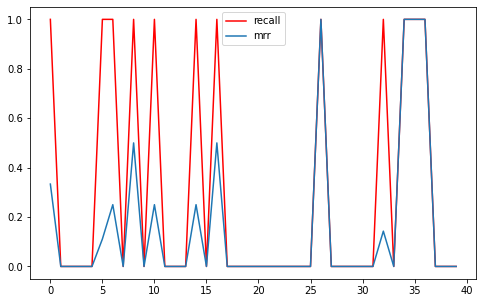

Train:   0%|          | 0/326 [00:00<?, ?it/s, accuracy=0.5, train_loss=4.15] 

	 - Recall@10 epoch 5: 0.300000
	 - MRR@10    epoch 5: 0.158433



Evaluation:  67%|██████▋   | 10/15 [00:00<00:00, 21.48it/s]


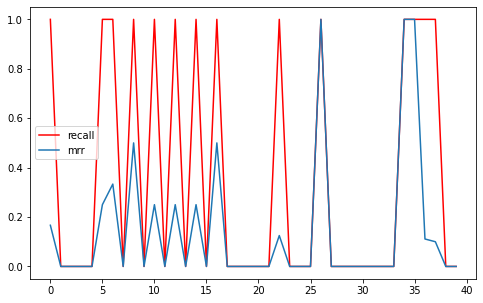

Train:   0%|          | 0/326 [00:00<?, ?it/s, accuracy=0, train_loss=4.63]   

	 - Recall@10 epoch 6: 0.350000
	 - MRR@10    epoch 6: 0.145903



Evaluation:  67%|██████▋   | 10/15 [00:00<00:00, 21.63it/s]


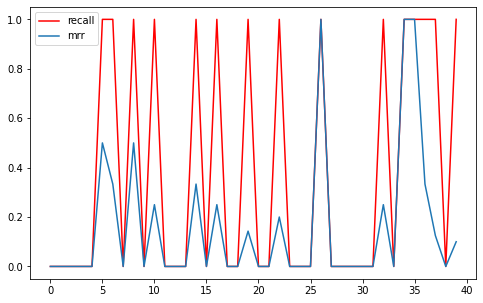

Train:   0%|          | 0/326 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.13]

	 - Recall@10 epoch 7: 0.375000
	 - MRR@10    epoch 7: 0.157946



Evaluation:  67%|██████▋   | 10/15 [00:00<00:00, 21.79it/s]


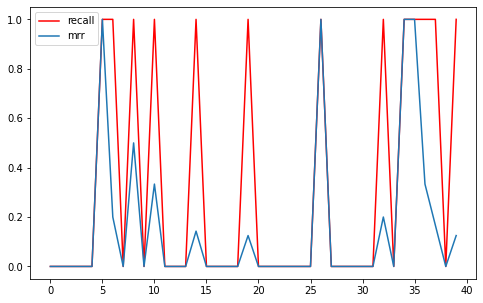

Train:   0%|          | 0/326 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.84]

	 - Recall@10 epoch 8: 0.325000
	 - MRR@10    epoch 8: 0.153155



Evaluation:  67%|██████▋   | 10/15 [00:00<00:00, 21.73it/s]


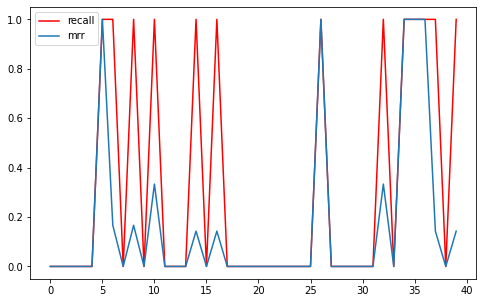

Train:   0%|          | 0/326 [00:00<?, ?it/s, accuracy=0.25, train_loss=4.08]

	 - Recall@10 epoch 9: 0.325000
	 - MRR@10    epoch 9: 0.164286



Evaluation:  67%|██████▋   | 10/15 [00:00<00:00, 21.51it/s]


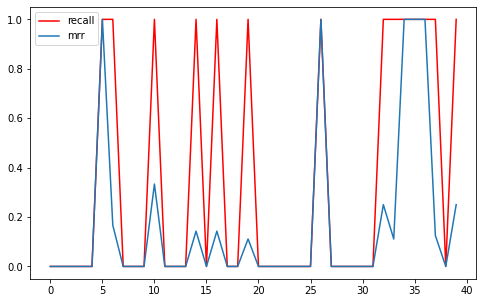

	 - Recall@10 epoch 10: 0.350000
	 - MRR@10    epoch 10: 0.165823



(0.35, 0.1658234126984127)

In [139]:
args = Args(tr, val, test, batch_size=4, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=10)
model = create_model(args)
train_model(model, args)

## 3개월치 데이터 사용

In [124]:
data_3 = get_data_before_month(data, 3)
data_3 = cleanse_recursive(data_3, shortest=2, least_click=5)

length:4610
oldest: 2002-11-30 20:24:52+00:00
latest: 2003-02-28 17:49:50+00:00


In [125]:
tr, test = split_by_date(data_3, n_days=5)
tr, val = split_by_date(tr, n_days=5)
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 1442
	 Sessions: 138
	 Items: 231
	 First Time : 2002-12-01 04:17:00+00:00
	 Last Time : 2003-02-18 17:36:46+00:00

* valid Set Stats Info
	 Events: 78
	 Sessions: 16
	 Items: 66
	 First Time : 2003-02-18 23:13:57+00:00
	 Last Time : 2003-02-23 17:44:04+00:00

* test Set Stats Info
	 Events: 86
	 Sessions: 12
	 Items: 71
	 First Time : 2003-02-23 17:48:03+00:00
	 Last Time : 2003-02-28 17:45:20+00:00



In [131]:
tr_3 = indexing(tr_3)
val_3 = indexing(val_3)
test_3 = indexing(test_3)

In [132]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train_1month.pkl')
val.to_pickle(save_path / 'valid_1month.pkl')
test.to_pickle(save_path / 'test_1month.pkl')

In [135]:
tr_3_dataset = SessionDataset(tr_3)
tr_3_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx


Train:   0%|          | 0/1304 [00:00<?, ?it/s]

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(1, 1, 231)]             0         
_________________________________________________________________
GRU (GRU)                    [(1, 50), (1, 50)]        42450     
_________________________________________________________________
dropout_8 (Dropout)          (1, 50)                   0         
_________________________________________________________________
dense_8 (Dense)              (1, 231)                  11781     
Total params: 54,231
Trainable params: 54,231
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 62/62 [00:02<00:00, 23.77it/s]


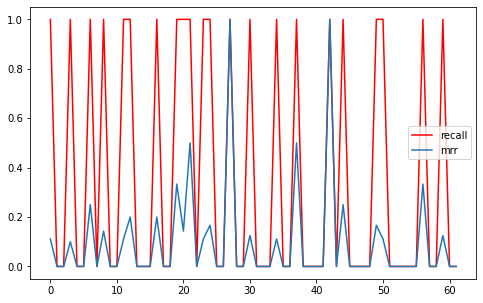

Train:   0%|          | 0/1304 [00:00<?, ?it/s, accuracy=0, train_loss=5.25]

	 - Recall@10 epoch 1: 0.354839
	 - MRR@10    epoch 1: 0.098246



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 26.93it/s]


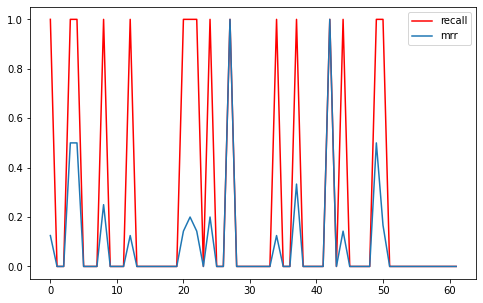

Train:   0%|          | 0/1304 [00:00<?, ?it/s, accuracy=0, train_loss=5.38]

	 - Recall@10 epoch 2: 0.258065
	 - MRR@10    epoch 2: 0.087961



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 26.29it/s]


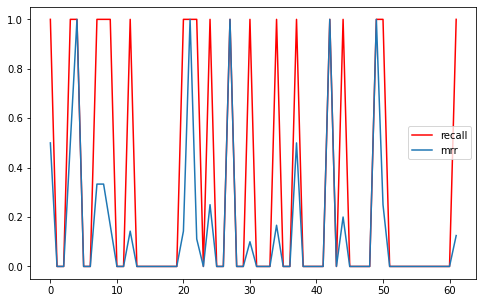

Train:   0%|          | 0/1304 [00:00<?, ?it/s, accuracy=0, train_loss=5.01]

	 - Recall@10 epoch 3: 0.322581
	 - MRR@10    epoch 3: 0.142288



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 26.94it/s]


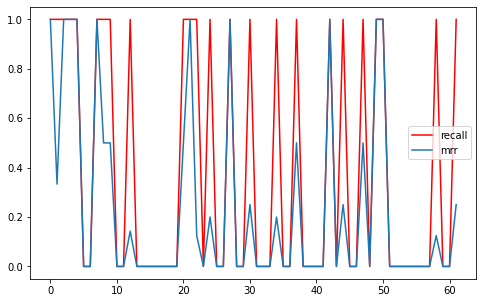

Train:   0%|          | 0/1304 [00:00<?, ?it/s, accuracy=0, train_loss=4.99]

	 - Recall@10 epoch 4: 0.387097
	 - MRR@10    epoch 4: 0.231874



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 27.29it/s]


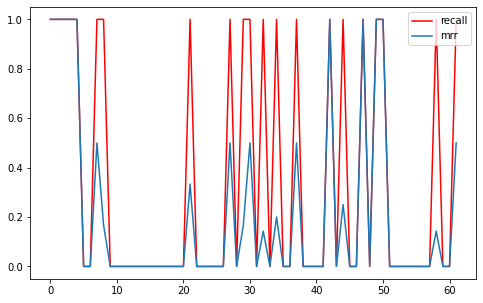

Train:   0%|          | 0/1304 [00:00<?, ?it/s, accuracy=0, train_loss=4.34] 

	 - Recall@10 epoch 5: 0.338710
	 - MRR@10    epoch 5: 0.208103



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 27.45it/s]


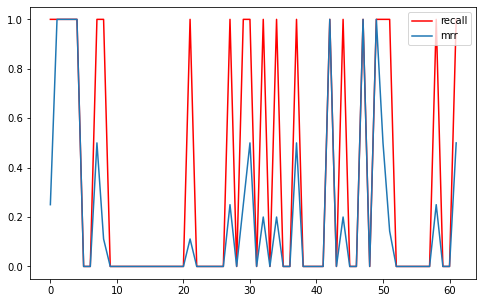

Train:   0%|          | 0/1304 [00:00<?, ?it/s, accuracy=0, train_loss=4.35] 

	 - Recall@10 epoch 6: 0.354839
	 - MRR@10    epoch 6: 0.184921



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 27.13it/s]


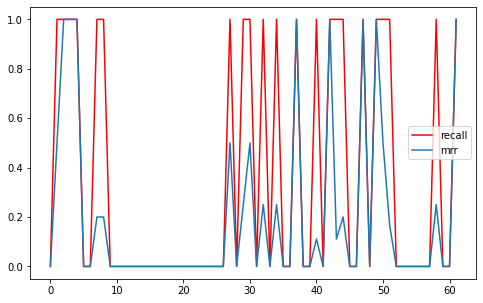

Train:   0%|          | 0/1304 [00:00<?, ?it/s, accuracy=0, train_loss=3.87]  

	 - Recall@10 epoch 7: 0.354839
	 - MRR@10    epoch 7: 0.193369



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 27.27it/s]


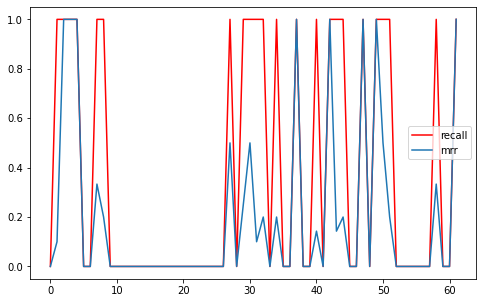

Train:   0%|          | 0/1304 [00:00<?, ?it/s, accuracy=0, train_loss=4.23]   

	 - Recall@10 epoch 8: 0.370968
	 - MRR@10    epoch 8: 0.191974



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 27.21it/s]


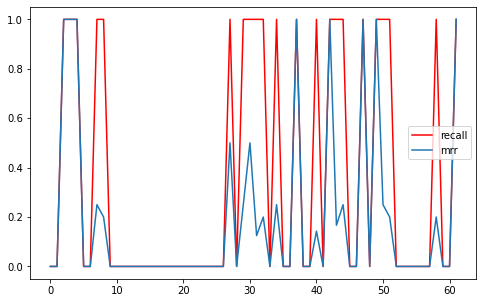

Train:   0%|          | 0/1304 [00:00<?, ?it/s, accuracy=0, train_loss=3.4]   

	 - Recall@10 epoch 9: 0.354839
	 - MRR@10    epoch 9: 0.185234



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 26.89it/s]


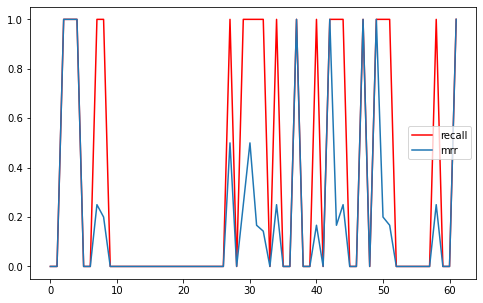

	 - Recall@10 epoch 10: 0.354839
	 - MRR@10    epoch 10: 0.184831



(0.3548387096774194, 0.18483102918586788)

In [136]:
args = Args(tr, val, test, batch_size=1, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=10)
model = create_model(args)
train_model(model, args)

## 6개월치 사용

In [140]:
data_6 = get_data_before_month(data, 6)
data_6 = cleanse_recursive(data_1, shortest=2, least_click=5)

length:8806
oldest: 2002-09-01 19:41:39+00:00
latest: 2003-02-28 17:49:50+00:00


In [141]:
tr, test = split_by_date(data_6, n_days=5)
tr, val = split_by_date(tr, n_days=5)
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 19
	 Sessions: 4
	 Items: 7
	 First Time : 2003-02-01 02:39:15+00:00
	 Last Time : 2003-02-10 18:22:34+00:00

* valid Set Stats Info
	 Events: 9
	 Sessions: 2
	 Items: 6
	 First Time : 2003-02-16 23:59:49+00:00
	 Last Time : 2003-02-21 21:22:26+00:00

* test Set Stats Info
	 Events: 7
	 Sessions: 3
	 Items: 5
	 First Time : 2003-02-24 17:02:07+00:00
	 Last Time : 2003-02-27 18:15:10+00:00



In [142]:
tr = indexing(tr)
val = indexing(val)
test = indexing(test)

In [143]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train_1month.pkl')
val.to_pickle(save_path / 'valid_1month.pkl')
test.to_pickle(save_path / 'test_1month.pkl')

In [144]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
58836,398,2028,4,2003-02-06 21:03:45+00:00,0
58784,398,2762,5,2003-02-06 21:09:13+00:00,1
58730,398,2628,3,2003-02-06 21:18:16+00:00,2
58837,398,3697,2,2003-02-06 21:21:04+00:00,3
58645,398,1196,4,2003-02-06 21:39:01+00:00,4
62105,419,2424,4,2003-02-10 18:10:24+00:00,5
62170,419,2028,5,2003-02-10 18:13:21+00:00,0
62078,419,1196,5,2003-02-10 18:15:20+00:00,4
62145,419,2762,5,2003-02-10 18:22:08+00:00,1
62071,419,3793,4,2003-02-10 18:22:34+00:00,6


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(2, 1, 7)]               0         
_________________________________________________________________
GRU (GRU)                    [(2, 50), (2, 50)]        8850      
_________________________________________________________________
dropout_16 (Dropout)         (2, 50)                   0         
_________________________________________________________________
dense_16 (Dense)             (2, 7)                    357       
Total params: 9,207
Trainable params: 9,207
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 3/3 [00:00<00:00,  7.17it/s]


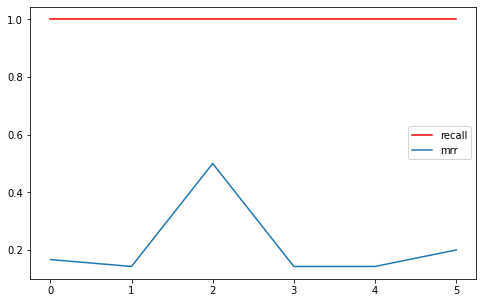

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 27.12it/s]

	 - Recall@10 epoch 1: 1.000000
	 - MRR@10    epoch 1: 0.215873



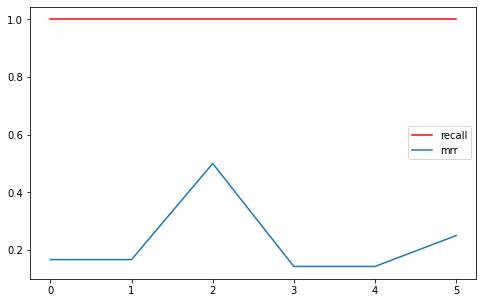

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 24.36it/s]

	 - Recall@10 epoch 2: 1.000000
	 - MRR@10    epoch 2: 0.228175



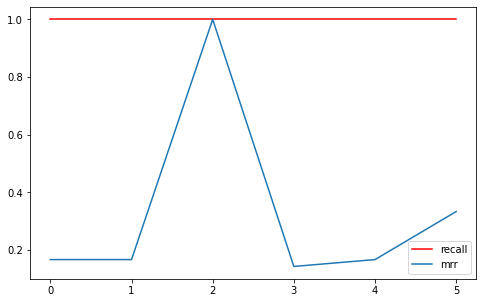

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 25.64it/s]

	 - Recall@10 epoch 3: 1.000000
	 - MRR@10    epoch 3: 0.329365



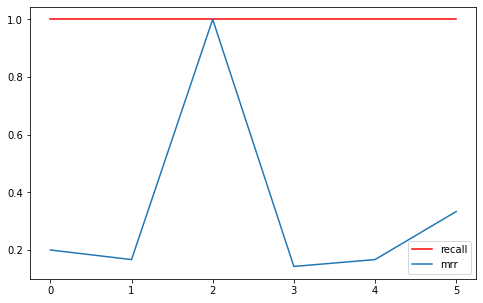

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 27.14it/s]

	 - Recall@10 epoch 4: 1.000000
	 - MRR@10    epoch 4: 0.334921



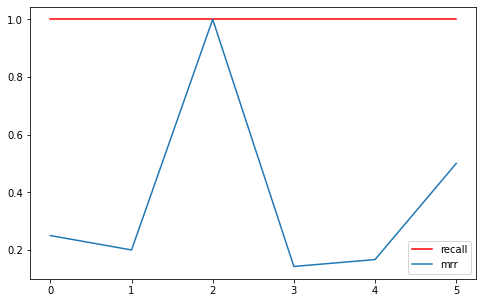

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 27.03it/s]

	 - Recall@10 epoch 5: 1.000000
	 - MRR@10    epoch 5: 0.376587



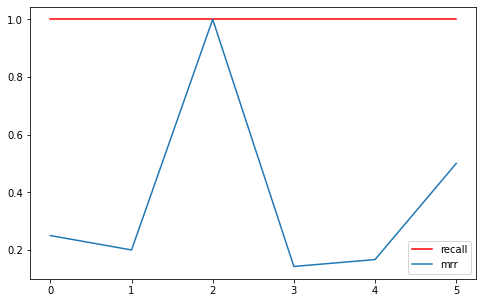

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 25.64it/s]

	 - Recall@10 epoch 6: 1.000000
	 - MRR@10    epoch 6: 0.376587



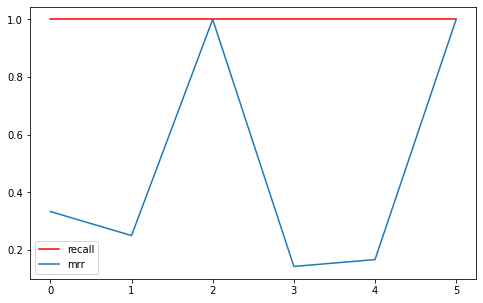

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 25.86it/s]

	 - Recall@10 epoch 7: 1.000000
	 - MRR@10    epoch 7: 0.482143



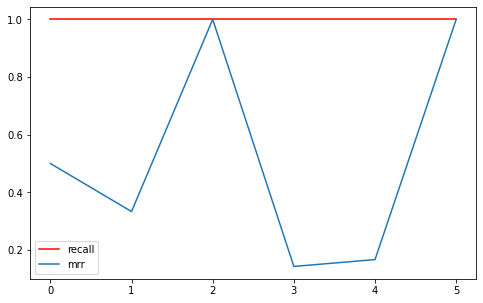

Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

	 - Recall@10 epoch 8: 1.000000
	 - MRR@10    epoch 8: 0.523810



Evaluation: 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]


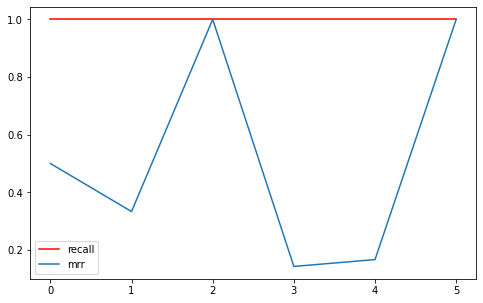

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.76it/s]

	 - Recall@10 epoch 9: 1.000000
	 - MRR@10    epoch 9: 0.523810



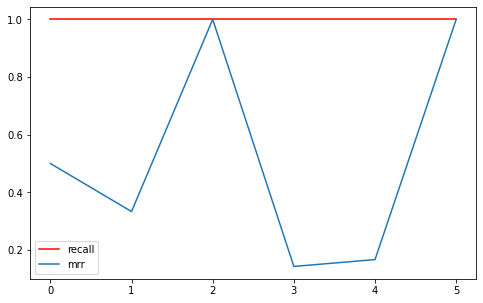

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.97it/s]

	 - Recall@10 epoch 10: 1.000000
	 - MRR@10    epoch 10: 0.523810



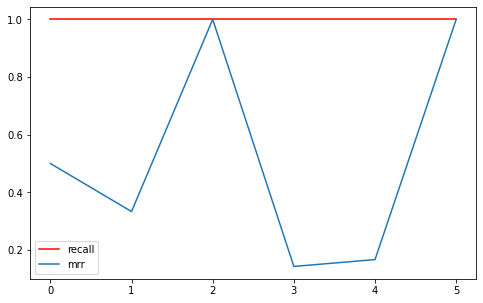

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.75it/s]

	 - Recall@10 epoch 11: 1.000000
	 - MRR@10    epoch 11: 0.523810



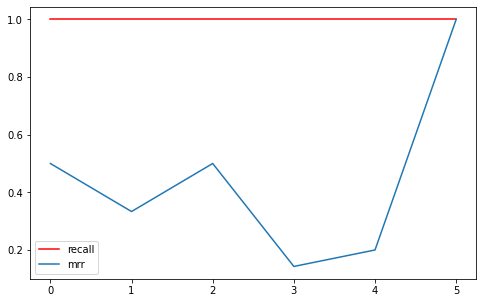

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 22.01it/s]

	 - Recall@10 epoch 12: 1.000000
	 - MRR@10    epoch 12: 0.446032



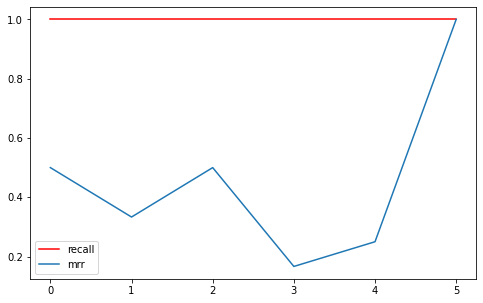

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.95it/s]

	 - Recall@10 epoch 13: 1.000000
	 - MRR@10    epoch 13: 0.458333



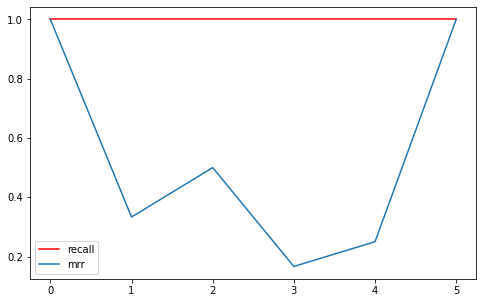

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 24.64it/s]

	 - Recall@10 epoch 14: 1.000000
	 - MRR@10    epoch 14: 0.541667



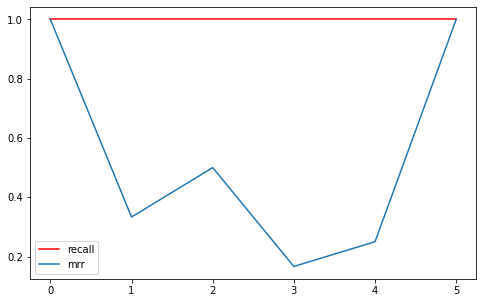

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.44it/s]

	 - Recall@10 epoch 15: 1.000000
	 - MRR@10    epoch 15: 0.541667



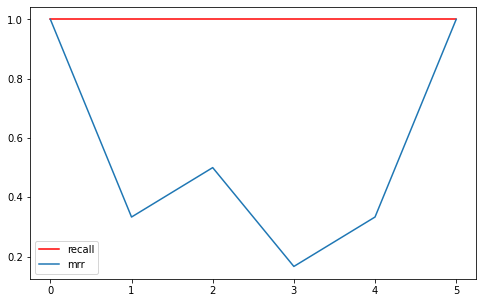

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 25.72it/s]

	 - Recall@10 epoch 16: 1.000000
	 - MRR@10    epoch 16: 0.555556



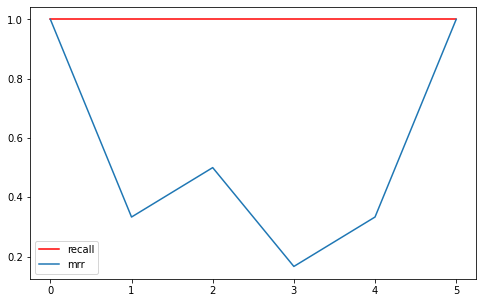

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.67it/s]

	 - Recall@10 epoch 17: 1.000000
	 - MRR@10    epoch 17: 0.555556



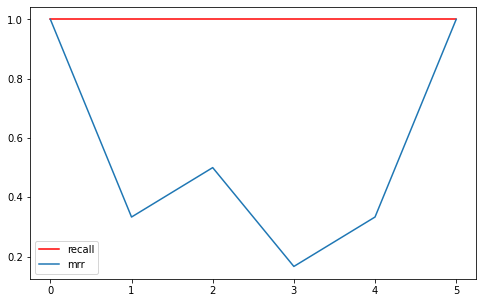

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.88it/s]

	 - Recall@10 epoch 18: 1.000000
	 - MRR@10    epoch 18: 0.555556



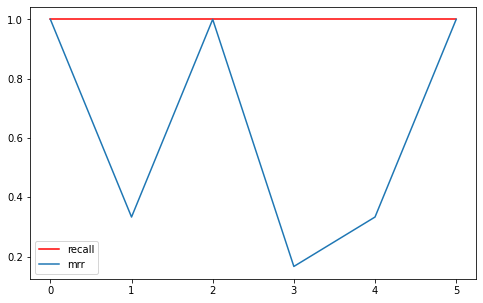

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 27.16it/s]

	 - Recall@10 epoch 19: 1.000000
	 - MRR@10    epoch 19: 0.638889



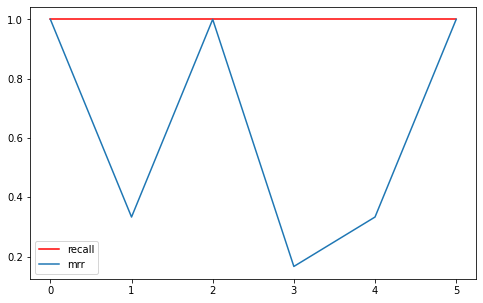

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 24.53it/s]

	 - Recall@10 epoch 20: 1.000000
	 - MRR@10    epoch 20: 0.638889



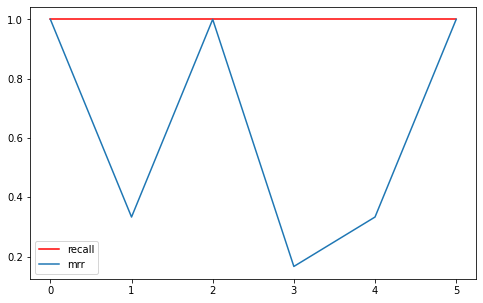

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 25.68it/s]

	 - Recall@10 epoch 21: 1.000000
	 - MRR@10    epoch 21: 0.638889



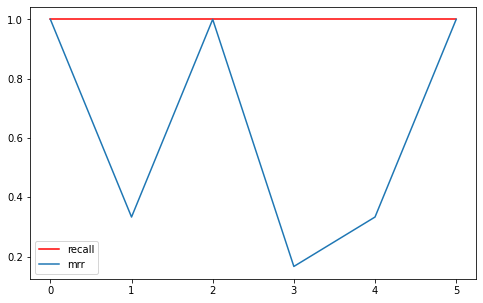

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.63it/s]

	 - Recall@10 epoch 22: 1.000000
	 - MRR@10    epoch 22: 0.638889



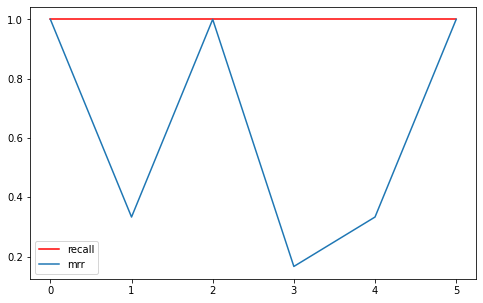

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 25.65it/s]

	 - Recall@10 epoch 23: 1.000000
	 - MRR@10    epoch 23: 0.638889



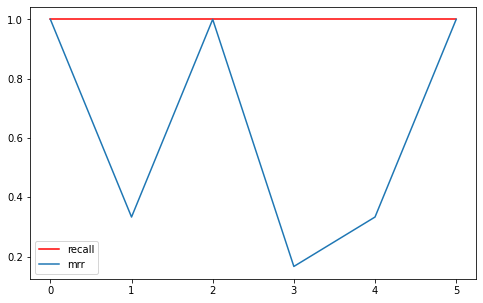

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 25.16it/s]

	 - Recall@10 epoch 24: 1.000000
	 - MRR@10    epoch 24: 0.638889



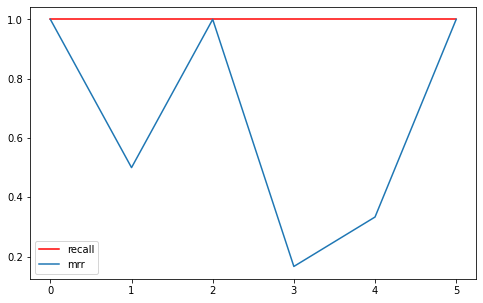

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 24.95it/s]

	 - Recall@10 epoch 25: 1.000000
	 - MRR@10    epoch 25: 0.666667



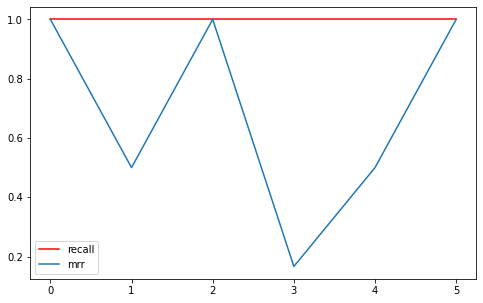

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.85it/s]

	 - Recall@10 epoch 26: 1.000000
	 - MRR@10    epoch 26: 0.694444



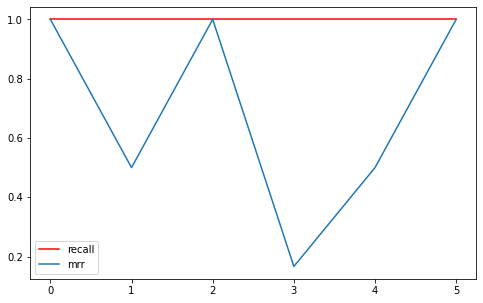

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 27.35it/s]

	 - Recall@10 epoch 27: 1.000000
	 - MRR@10    epoch 27: 0.694444



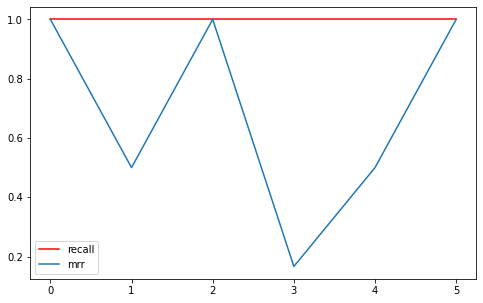

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 26.26it/s]

	 - Recall@10 epoch 28: 1.000000
	 - MRR@10    epoch 28: 0.694444



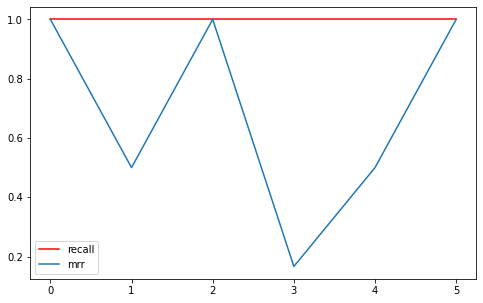

Evaluation: 100%|██████████| 3/3 [00:00<00:00, 25.72it/s]

	 - Recall@10 epoch 29: 1.000000
	 - MRR@10    epoch 29: 0.694444



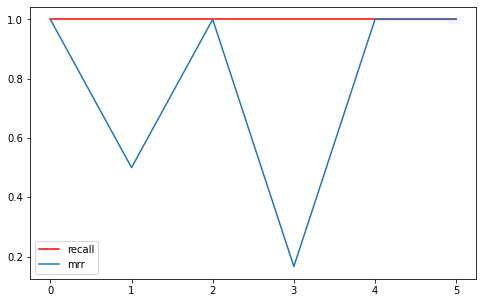

	 - Recall@10 epoch 30: 1.000000
	 - MRR@10    epoch 30: 0.777778



(1.0, 0.7777777777777777)

In [150]:
args = Args(tr, val, test, batch_size=2, hsz=50, drop_rate=0.2, lr=0.001, epochs=30, k=10)
model = create_model(args)
train_model(model, args)

## 12개월치 데이터를 사용했을 때

In [153]:
data_12 = get_data_before_month(data, 12)
data_12 = cleanse_recursive(data_12, shortest=2, least_click=5)


length:21055
oldest: 2002-03-05 18:25:38+00:00
latest: 2003-02-28 17:49:50+00:00


In [154]:
tr, test = split_by_date(data_12, n_days=30)
tr, val = split_by_date(tr, n_days=60)
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 14018
	 Sessions: 414
	 Items: 1504
	 First Time : 2002-03-05 18:25:38+00:00
	 Last Time : 2002-11-30 13:47:32+00:00

* valid Set Stats Info
	 Events: 2668
	 Sessions: 192
	 Items: 1141
	 First Time : 2002-11-30 20:24:52+00:00
	 Last Time : 2003-01-29 17:00:13+00:00

* test Set Stats Info
	 Events: 1356
	 Sessions: 95
	 Items: 828
	 First Time : 2003-01-29 19:36:56+00:00
	 Last Time : 2003-02-28 17:49:50+00:00



In [155]:
tr = indexing(tr)
val = indexing(val)
test = indexing(test)

In [156]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train_1month.pkl')
val.to_pickle(save_path / 'valid_1month.pkl')
test.to_pickle(save_path / 'test_1month.pkl')

In [157]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,2002-03-12 03:46:59+00:00,0
5267,36,1201,4,2002-03-12 03:46:59+00:00,1
5122,36,1291,5,2002-03-12 03:47:16+00:00,2
5123,36,2167,5,2002-03-12 03:48:25+00:00,3
5290,36,2951,4,2002-03-12 03:48:25+00:00,4
5359,36,2115,5,2002-03-12 03:48:25+00:00,5
5073,36,1912,5,2002-03-12 03:48:44+00:00,6
5113,36,2662,3,2002-03-12 03:48:44+00:00,7
5366,36,2985,4,2002-03-12 03:49:01+00:00,8
5145,36,198,5,2002-03-12 03:49:48+00:00,9


Train:   0%|          | 0/13604 [00:00<?, ?it/s]

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(1, 1, 1504)]            0         
_________________________________________________________________
GRU (GRU)                    [(1, 50), (1, 50)]        233400    
_________________________________________________________________
dropout_17 (Dropout)         (1, 50)                   0         
_________________________________________________________________
dense_17 (Dense)             (1, 1504)                 76704     
Total params: 310,104
Trainable params: 310,104
Non-trainable params: 0
_________________________________________________________________


Evaluation: 100%|██████████| 2476/2476 [01:34<00:00, 26.17it/s]


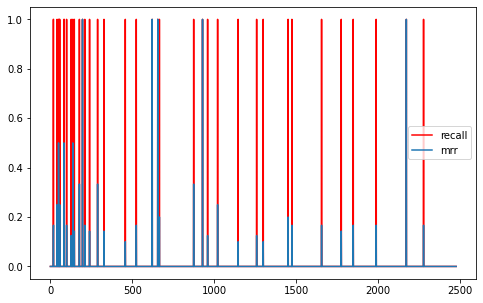

Train:   0%|          | 0/13604 [00:00<?, ?it/s, accuracy=0, train_loss=6.65]

	 - Recall@10 epoch 1: 0.015751
	 - MRR@10    epoch 1: 0.004874



Evaluation: 100%|██████████| 2476/2476 [01:41<00:00, 24.41it/s]


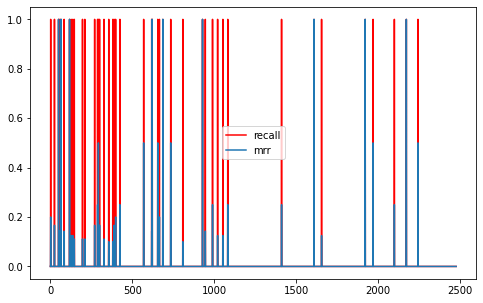

Train:   0%|          | 0/13604 [00:00<?, ?it/s, accuracy=0, train_loss=6.51]

	 - Recall@10 epoch 2: 0.018174
	 - MRR@10    epoch 2: 0.006793



Evaluation: 100%|██████████| 2476/2476 [01:35<00:00, 25.91it/s]


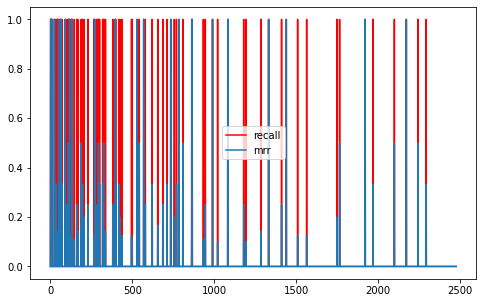

Train:   0%|          | 0/13604 [00:00<?, ?it/s, accuracy=0, train_loss=5.71]

	 - Recall@10 epoch 3: 0.034733
	 - MRR@10    epoch 3: 0.016407



Evaluation: 100%|██████████| 2476/2476 [01:36<00:00, 25.56it/s]


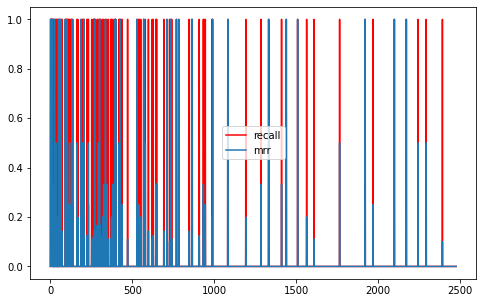

Train:   0%|          | 0/13604 [00:00<?, ?it/s, accuracy=0, train_loss=5.6] 

	 - Recall@10 epoch 4: 0.049677
	 - MRR@10    epoch 4: 0.024190



Evaluation: 100%|██████████| 2476/2476 [01:37<00:00, 25.48it/s]


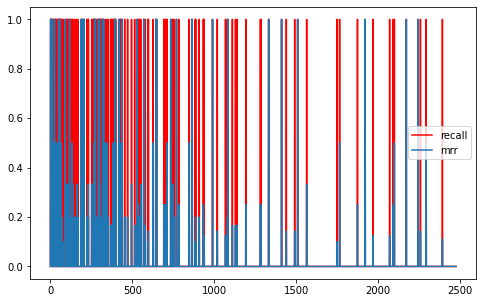

Train:   0%|          | 0/13604 [00:00<?, ?it/s, accuracy=0, train_loss=5.47] 

	 - Recall@10 epoch 5: 0.065024
	 - MRR@10    epoch 5: 0.029332



Evaluation: 100%|██████████| 2476/2476 [01:36<00:00, 25.65it/s]


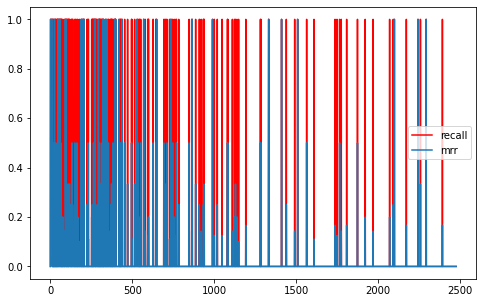

Train:   0%|          | 0/13604 [00:00<?, ?it/s, accuracy=0, train_loss=5.72] 

	 - Recall@10 epoch 6: 0.079564
	 - MRR@10    epoch 6: 0.035622



Evaluation: 100%|██████████| 2476/2476 [01:30<00:00, 27.27it/s]


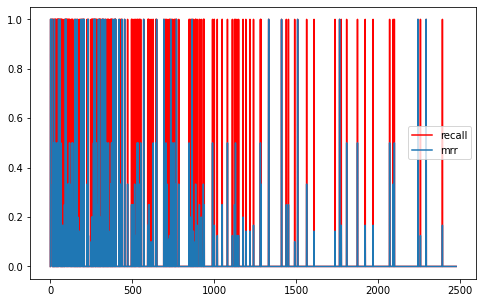

Train:   0%|          | 0/13604 [00:00<?, ?it/s, accuracy=0, train_loss=6.72]  

	 - Recall@10 epoch 7: 0.089661
	 - MRR@10    epoch 7: 0.039781



Evaluation: 100%|██████████| 2476/2476 [01:32<00:00, 26.70it/s]


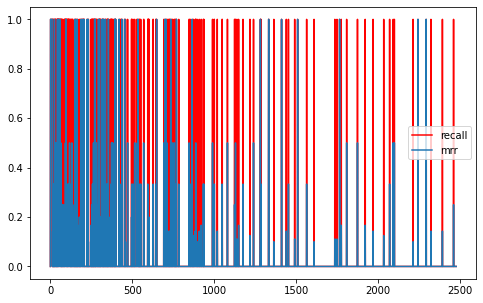

Train:   0%|          | 0/13604 [00:00<?, ?it/s, accuracy=0, train_loss=6.33] 

	 - Recall@10 epoch 8: 0.094103
	 - MRR@10    epoch 8: 0.040894



Evaluation: 100%|██████████| 2476/2476 [01:29<00:00, 27.78it/s]


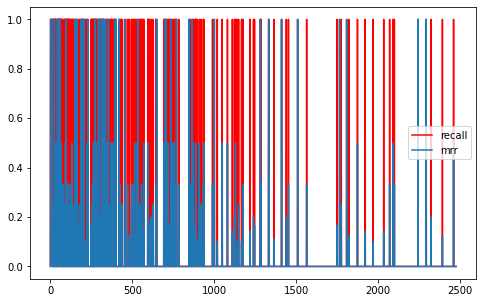

Train:   0%|          | 0/13604 [00:00<?, ?it/s, accuracy=0, train_loss=6.28]  

	 - Recall@10 epoch 9: 0.100969
	 - MRR@10    epoch 9: 0.042741



Evaluation: 100%|██████████| 2476/2476 [01:27<00:00, 28.40it/s]


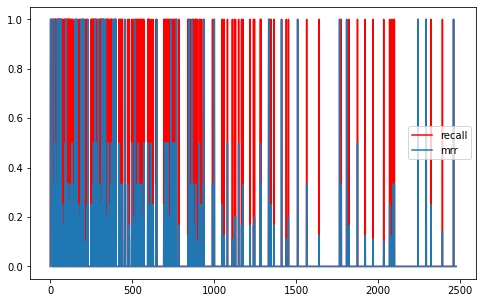

	 - Recall@10 epoch 10: 0.106220
	 - MRR@10    epoch 10: 0.042810



(0.10621970920840064, 0.04280986357924969)

In [158]:
args = Args(tr, val, test, batch_size=1, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=10)
model = create_model(args)
train_model(model, args)

## Final results comparision

<original>
    
- Recall@20: 0.153320
    
- MRR@20: 0.047378


<1개월>
    
 - Recall = 0.35
 - MRR = 0.1658234126984127

<3개월>
    
 - Recall = 0.3548387096774194 (best)
    
 - MRR = 0.18483102918586788


<6개월>
    
 - Recall = 0.35
 - MRR = 0.1658234126984127

<12개월>
    
 - Recall = 0.10621970920840064
 - MRR = 0.04280986357924969)

## 회고
1️⃣ 잘한 점:

히스토그램으로 data([Rating])을 확인해봤다.
2️⃣ 어려웠던 점:

3개월 6개월 12개월 순으로 기간의 기준을 바꾸어서 학습을 시켜보고자 했는데 왠지 모르게 1개월 기준으로 한 데이터를 모델에 넣을 때 에러가 났었다. ("index 16 is out of bounds for axis 0 with size 16") 그리고 데이터 값들이 사라지는 오류를 만들어냈다. (신기하게도 column들의 첫 값들은 유지됌). 그래서 학습을 못 시켜본게 아쉽다. --> 신기하게도 기준 개월수를 높일수록 (1->3->6->12) 배치사이즈를 줄여줘야 에러가 나지 않았다. (debugging 완료!)

모델 훈련시키는데 시간이 오래걸려서 다양한 시도를 하기 어려웠다.

Session-Based Recommendation 개념을 이해하는게 어렵다.


어느부분을 수정을 해야하는지, 어쩨서 실행이 안되는지 에러코드만으로는 이해하고 이를 수정하기 어려웠다.


3️⃣ 느낀 점:

RNN 계열로도 추천시스템을 만들 수 있다는 점에서 놀랐다. 특히, 특정한 시계열 데이터를 사용해서 추천하는 시스템을 제작할 수 있다는 것이 신기했다. 하지만, 이러한 모델을 학습시키는 시간이 길어서 다양한 시도를 하지 못한게 아쉽다.